In [3]:
import xarray as xr
import numpy as np
from xgcm.grid import Grid
from dask.diagnostics import ProgressBar
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
from glob import glob

In [15]:
XG=np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/XG.data', dtype='>f4')
YG=np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/YG.data', dtype='>f4')
YC=np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/YC.data', dtype='>f4')
YC = YC.reshape(2160,2160)
YG = YG.reshape(2160,2160)
DYG=np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/DYG.data', dtype='>f4')
DXG=np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/DXG.data', dtype='>f4')
DXG = DXG.reshape(2160,2160)
DYG = DYG.reshape(2160,2160)
DYC=np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/DYC.data', dtype='>f4')
DXC=np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/DXC.data', dtype='>f4')
DXC = DXC.reshape(2160,2160)
DYC = DYC.reshape(2160,2160)

In [5]:
def lanczos(x, a):
    return np.sinc(x/a)

In [36]:
fnames = sorted(glob(f'/swot/SUM01/spencer/36hr_timeseries/*.zarr'))
nofiles = len(fnames)
for fileno in range(0,33):#nofiles
        print('/swot/SUM01/spencer/36hr_timeseries/rechunked_' + str(6048+fileno*144) +'.zarr')
        ds = xr.open_zarr('/swot/SUM01/spencer/36hr_timeseries/rechunked_' + str(6048+fileno*144) +'.zarr')
        ds = ds.isel(niter=slice(1,74))
        ds['time'] = ds['niter']*3600/144
        ds = ds.assign_coords({"time": ds.time})
        ds = ds.swap_dims({"niter": "time"})
        ds = ds.where(ds.u!=-999)
        window_width=20
        weight = xr.DataArray(lanczos(np.arange(-window_width/2,window_width/2), window_width/2), dims=['window'])
        windowed_u = ds.u.rolling(time=window_width, center=True).construct('window').dot(weight)/np.sum(weight)
        windowed_v = ds.v.rolling(time=window_width, center=True).construct('window').dot(weight)/np.sum(weight)
        windowed_eta = ds.eta.rolling(time=window_width, center=True).construct('window').dot(weight)/np.sum(weight)
        u_piece = windowed_u.sel(time=0).isel(z0=2)
        v_piece = windowed_v.sel(time=0).isel(z0=2)
        eta_piece = windowed_eta.sel(time=0).isel(z0=2)
        u_piece2 = ds.u.sel(time=0).isel(z0=2)
        v_piece2 = ds.v.sel(time=0).isel(z0=2)
        eta_piece2 = ds.eta.sel(time=0).isel(z0=2)
        u_piece["time"] = fileno*3600
        v_piece["time"] = fileno*3600
        eta_piece["time"] = fileno*3600
        u_piece2["time"] = fileno*3600
        v_piece2["time"] = fileno*3600
        eta_piece2["time"] = fileno*3600
        if fileno==0:
            u_filtered = u_piece
            v_filtered = v_piece
            eta_filtered = eta_piece
            u_unfiltered = u_piece2
            v_unfiltered = v_piece2
            eta_unfiltered = eta_piece2
        else:
            u_filtered = xr.concat([u_filtered,u_piece],dim='time')
            v_filtered = xr.concat([v_filtered,v_piece],dim='time')
            eta_filtered = xr.concat([eta_filtered,eta_piece],dim='time')
            u_unfiltered = xr.concat([u_unfiltered,u_piece2],dim='time')
            v_unfiltered = xr.concat([v_unfiltered,v_piece2],dim='time')
            eta_unfiltered = xr.concat([eta_unfiltered,eta_piece2],dim='time')

/swot/SUM01/spencer/36hr_timeseries/rechunked_6048.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_6192.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_6336.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_6480.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_6624.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_6768.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_6912.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_7056.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_7200.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_7344.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_7488.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_7632.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_7776.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_7920.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_8064.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_8208.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_8352.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_84

In [37]:
# interpolate onto C-grid
grid = Grid(u_filtered, coords={'X': {'center': 'x0', 'left': 'x0_g'}, 'Y': {'center': 'y0', 'left': 'y0_g'}})
u_fil = grid.interp(u_filtered,'X')
v_fil = grid.interp(v_filtered,'Y')
u_unfil = grid.interp(u_unfiltered,'X')
v_unfil = grid.interp(v_unfiltered,'Y')

YG_g = xr.DataArray(YG, dims=["y0_g", "x0"],coords=dict(j=(["y0_g"], u_fil.y0),i_g=(["x0"], u_fil.x0_g)))
YC_g = xr.DataArray(YC, dims=["y0", "x0_g"],coords=dict(j=(["y0"], u_fil.y0),i_g=(["x0_g"], u_fil.x0_g)))

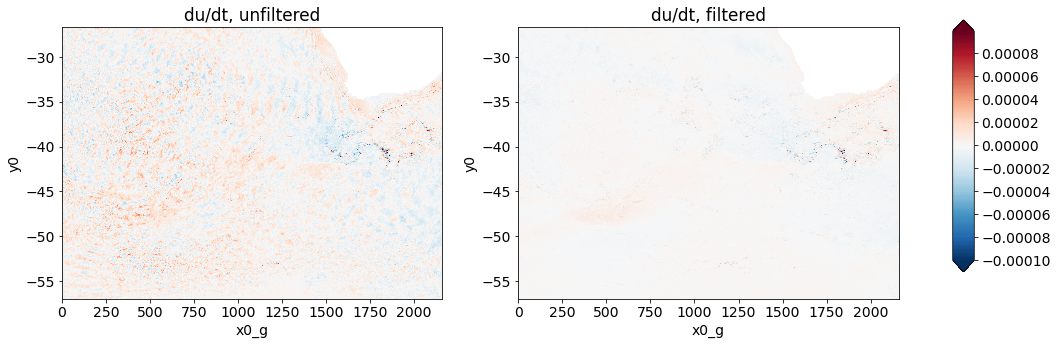

In [32]:
#centered difference differentiation
dudt_un = u_unfil.chunk({'time':-1}).differentiate('time')
dvdt_un = v_unfil.chunk({'time':-1}).differentiate('time')
dudt_f = u_fil.chunk({'time':-1}).differentiate('time')
dvdt_f = v_fil.chunk({'time':-1}).differentiate('time')

plt.figure(figsize=(15,5))
plt.subplot(121)
dudt_un.isel(time=0).plot(x='x0_g',y='y0',levels=np.arange(-1,1,0.01)*10**-4,add_colorbar=False)
plt.title('du/dt, unfiltered')

plt.subplot(122)
cs = dudt_f.isel(time=0).plot(x='x0_g',y='y0',levels=np.arange(-1,1,0.01)*10**-4,add_colorbar=False)
plt.title('du/dt, filtered')

fig=plt.gcf()
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.2, 0.02, 0.7])
fig.colorbar(cs, cax=cbar_ax)

Text(0.5, 1.0, 'fv, filtered')

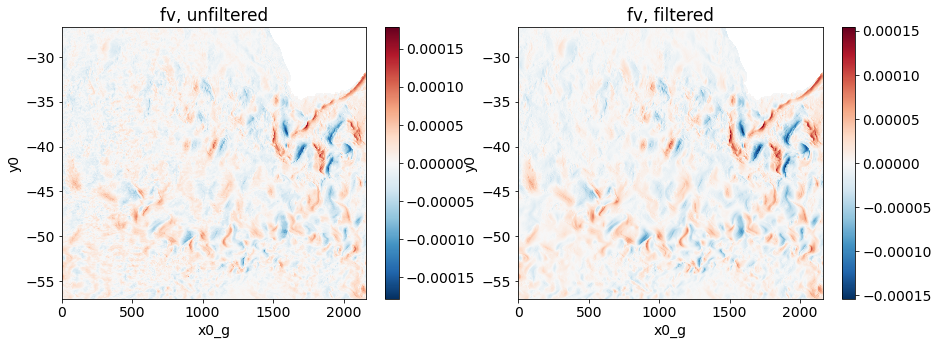

In [55]:
#calc u on v points and v on u points
fG = 2*2*np.pi/24/3600*np.sin(YG_g*np.pi/180)
fC = 2*2*np.pi/24/3600*np.sin(YC_g*np.pi/180)
fu_un = grid.interp(grid.interp(u_unfil,'X'),'Y')*fG
fv_un = grid.interp(grid.interp(v_unfil,'X'),'Y')*fC
fu_f = grid.interp(grid.interp(u_fil,'X'),'Y')*fG
fv_f = grid.interp(grid.interp(v_fil,'X'),'Y')*fC

plt.figure(figsize=(15,5))
plt.subplot(121)
fv_un.isel(time=0).plot(x='x0_g',y='y0')
plt.title('fv, unfiltered')

plt.subplot(122)
fv_f.isel(time=0).plot(x='x0_g',y='y0')
plt.title('fv, filtered')


Text(0.5, 1.0, 'dp/dx, filtered')

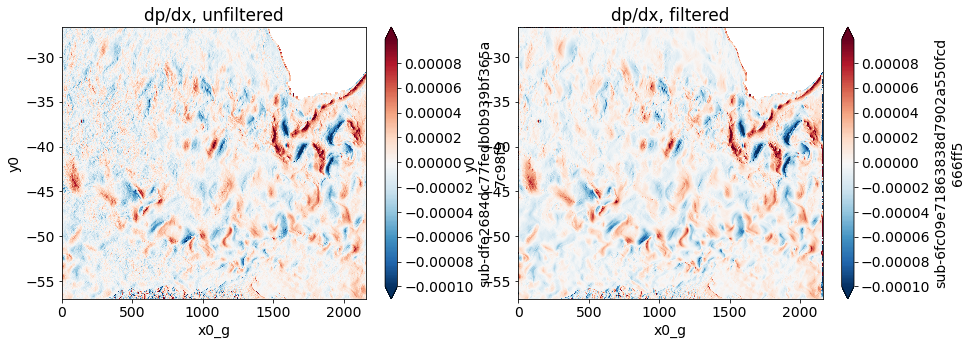

In [56]:
detadx_un = grid.diff(9.81*eta_unfiltered,'X')/DXC
detady_un = grid.diff(9.81*eta_unfiltered,'Y')/DYC

detadx_f = grid.diff(9.81*eta_filtered,'X')/DXC
detady_f = grid.diff(9.81*eta_filtered,'Y')/DYC


plt.figure(figsize=(15,5))
plt.subplot(121)
detadx_un.isel(time=0).plot(x='x0_g',y='y0',levels=np.arange(-1,1,0.01)*10**-4)
plt.title('dp/dx, unfiltered')

plt.subplot(122)
detadx_f.isel(time=0).plot(x='x0_g',y='y0',levels=np.arange(-1,1,0.01)*10**-4)
plt.title('dp/dx, filtered')

In [57]:
with ProgressBar():
    fv_un.compute()
    fv_f.compute()

[########################################] | 100% Completed |  5min 48.8s
[########################################] | 100% Completed |  4min 27.3s


[########################################] | 100% Completed |  1min 25.6s
[                                        ] | 0% Completed | 13.3s

/home/spencerj/.conda/envs/pangeo1/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed |  3min 28.4s
[########################################] | 100% Completed |  1min 54.8s
[                                        ] | 1% Completed |  9.1s

/home/spencerj/.conda/envs/pangeo1/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[###                                     ] | 9% Completed | 27.4s

/home/spencerj/.conda/envs/pangeo1/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


[########################################] | 100% Completed |  3min 35.0s


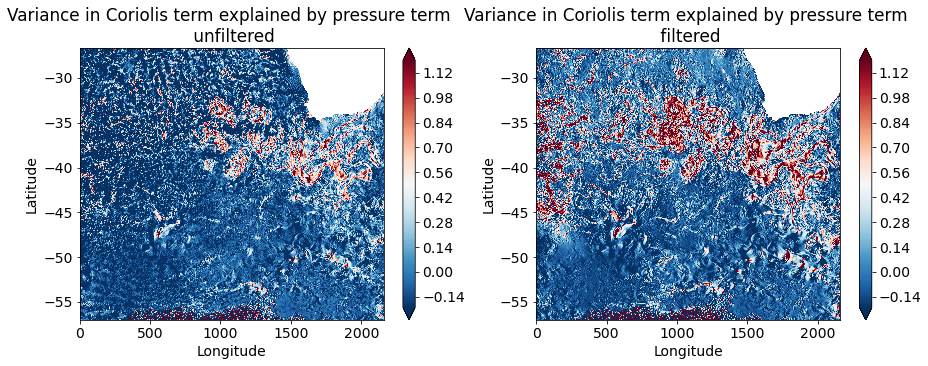

In [49]:
with ProgressBar():
    detadx_un_cov = ((xr.cov(detadx_un,fv_un,'time')
          )/xr.cov(fv_un,fv_un,'time')).compute()
    detadx_f_cov = ((xr.cov(detadx_f,fv_f,'time')
          )/xr.cov(fv_f,fv_f,'time')).compute()

plt.figure(figsize=(15,5))
plt.subplot(121)
detadx_un_cov.plot(x='x0_g',y='y0',levels=np.arange(-0.2,1.2,0.01))
plt.title('Variance in Coriolis term explained by pressure term \n unfiltered')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.subplot(122)
detadx_f_cov.plot(x='x0_g',y='y0',levels=np.arange(-0.2,1.2,0.01))
plt.title('Variance in Coriolis term explained by pressure term \n filtered')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

fig=plt.gcf()
fig.savefig('Lag_cor_pres_variance.png')

[########################################] | 100% Completed |  1min  6.5s
[                                        ] | 1% Completed |  2.8s

/home/spencerj/.conda/envs/pangeo1/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed |  1min 14.0s
[########################################] | 100% Completed |  1min 59.0s
[                                        ] | 1% Completed |  5.6s

/home/spencerj/.conda/envs/pangeo1/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[######                                  ] | 15% Completed | 23.4s

/home/spencerj/.conda/envs/pangeo1/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


[########################################] | 100% Completed |  1min 53.7s


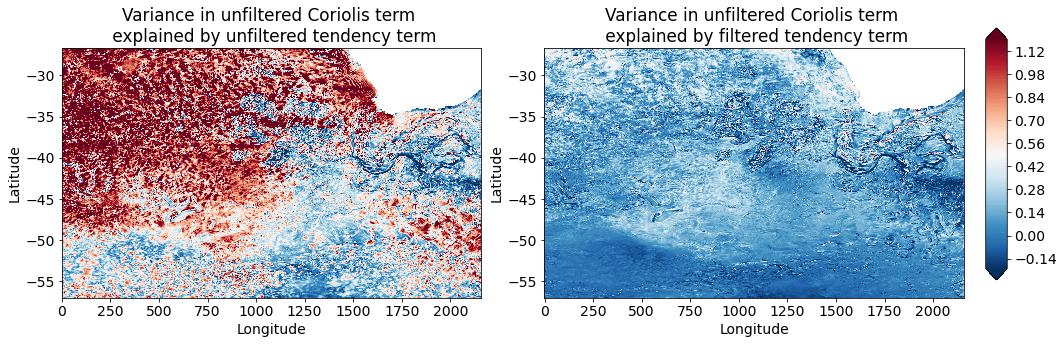

In [54]:
with ProgressBar():
    dudt_un_cov = ((xr.cov(dudt_un,fv_un,'time')
          )/xr.cov(fv_un,fv_un,'time')).compute()
    dudt_f_cov = ((xr.cov(dudt_f,fv_un,'time')
          )/xr.cov(fv_un,fv_un,'time')).compute()

plt.figure(figsize=(15,5))
plt.subplot(121)
dudt_un_cov.plot(x='x0_g',y='y0',levels=np.arange(-0.2,1.2,0.01),add_colorbar=False)
plt.title('Variance in unfiltered Coriolis term \n explained by unfiltered tendency term')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.subplot(122)
cs=dudt_f_cov.plot(x='x0_g',y='y0',levels=np.arange(-0.2,1.2,0.01),add_colorbar=False)
plt.title('Variance in unfiltered Coriolis term \n explained by filtered tendency term')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.tight_layout()

fig=plt.gcf()
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.2, 0.02, 0.7])
fig.colorbar(cs, cax=cbar_ax)

fig=plt.gcf()
fig.savefig('Lag_cor_tend_variance.png')

In [59]:
with ProgressBar():
    dudt_detadx_un_cov = (xr.cov((dudt_un+detadx_un),fv_un,'time'
      )/xr.cov(fv_un,fv_un,'time')).compute()
    dudt_detadx_f_cov = (xr.cov((dudt_f+detadx_f),fv_un,'time'
      )/xr.cov(fv_un,fv_un,'time')).compute()
    
dudt_detadx_un_cov.plot(x='x0_g',y='y0',levels=np.arange(-0.2,1.2,0.01))
plt.title('Variance in unfiltered Coriolis term \n explained by filtered tendency plus pressure term')

[########################################] | 100% Completed |  7min 12.5s
[########################################] | 100% Completed |  4min  4.2s
[                                        ] | 0% Completed | 48.1s


KeyboardInterrupt: 

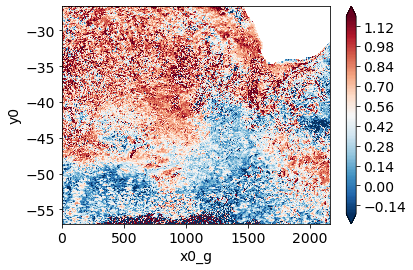

In [46]:
dudt_detadx_un_cov.plot(x='x0_g',y='y0',levels=np.arange(-0.2,1.2,0.01))